In [1]:
%%python3 -m venv .venv
%source .venv/bin/activate
%%python3 -m pip install torch numpy==1.21.4 pandas matplotlib pytorch-lightning librosa

In [6]:
# imports
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import numpy as np
import typing

# Project Overview
This project is intended to emulate real, hardware guitar pedals, which use analogue circuits to apply effects to audio signals, in software using a machine learning model

## Analyze audio signals
Our first step is to actually analyze our audio signals. We can use librosa, a package for audio analysis, for this

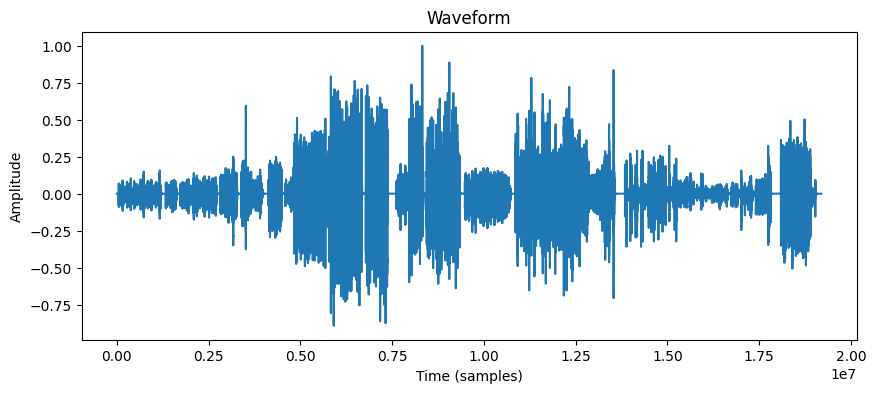

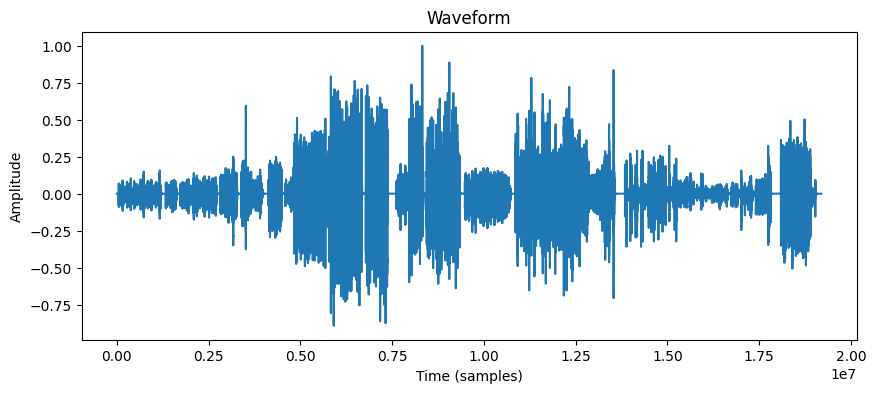

In [10]:
# data exploration to expand on later

def load_audio(file_path: str) -> tuple:
    audio_signal, sampling_rate = librosa.load(INPUT_FILE_PATH, sr=None)
    return audio_signal, sampling_rate

def plot_waveform(wave: np.ndarray) -> None:
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(wave)
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

inp_audio_signal, inp_sampling_rate = load_audio("./data/ML_Pedal_Input.wav")
out_audio_signal, out_sampling_rate = load_audio("./data/ML_Pedal_Output.wav")

plot_waveform(inp_audio_signal)
plot_waveform(out_audio_signal)

In [11]:
# turn into tensors for torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    return torch.tensor(data, dtype=float).unsqueeze(1)

inp_tensor = to_tensor(inp_audio_signal)
out_tensor = to_tensor(out_audio_signal)

print(f"Input Tensor Shape: {inp_tensor.shape}")
print(f"Target Tensor Shape: {out_tensor.shape}")

Input Tensor Shape: torch.Size([19189780, 1])
Target Tensor Shape: torch.Size([19189780, 1])
